#  Токсичные комменты русский, классификация

## Сведенья о датасете

### Ссылка
https://www.kaggle.com/blackmoon/russian-language-toxic-comments

### Описание переменных

| Название | Тип данных | Описание |
| ----------- | ----------- | ----------- |
| comment | string | Комментарии |
| toxic | float | Признак, являются ли токсичными. 1-являются, 0-не являются  |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import set_config
from ML_in_business.CourseProject.toxic_comment.metrictool import MetricRegressionManager

In [2]:
%matplotlib inline
set_config(display='diagram')

## Подготовка

In [3]:
# константы
TARGET = 'toxic'
COMMENT = 'comment'
COMMENT_VECTORIZER = 'comment_vectorizer'

In [4]:
# глобальные переменные
# Пусть:
#       штраф за пропущенный корректный коммент 100 р
#       штраф за пропущенный токсичный коммент в 10 р
metric_manager = MetricRegressionManager(
    fine_good=100,  # штраф за пропущенный корректный коммент
    fine_toxic=10,  # штраф за пропущенный токсичный коммент
    )

## Настройка Дата сета

In [5]:
# создаем датасет
#df = pd.read_csv("../data_folder/labeled.csv")
df = pd.read_csv("ML_in_business/CourseProject/toxic_comment/labeled.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [6]:
df[TARGET] = df[TARGET].astype('bool')
df[TARGET].value_counts(normalize=True)

False    0.66514
True     0.33486
Name: toxic, dtype: float64

In [7]:
# делим данные
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, 1), df[TARGET], test_size=0.3,  random_state=1)
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

<ipython-input-7-17fae9949ce8>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, 1), df[TARGET], test_size=0.3,  random_state=1)


False    0.669288
True     0.330712
Name: toxic, dtype: float64

## Настройка пайплайна

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from ML_in_business.CourseProject.toxic_comment.helper_dataset_transformations import TextCleanerTransform, Language, TextLemmatizationTransform
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to C:\Users\Alexander
[nltk_data]     Solomennik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Создадим пайплайн для LogisticRegression

In [9]:
from sklearn.linear_model import LogisticRegression

model_name = 'LogisticRegression'
text_transformer = Pipeline(steps=[
            ('clean', TextCleanerTransform(language = Language.Ru))
        ,   ('lemmatization', TextLemmatizationTransform(Language.Ru))
        ,   ('vectorizer', TfidfVectorizer(
                    sublinear_tf=True,      # Примените сублинейное масштабирование tf, т. е. замените tf на 1 + log(tf).
                    strip_accents='unicode',
                    analyzer='word',            
                    token_pattern=r'\w{1,}',# разделитель токена
                    #stop_words='english',
                    ngram_range=(1, 1),     # каждое слово отдельно
                    max_features=1000       # размер словаря
        ))
        ])

preprocessor = ColumnTransformer(
    transformers=[
        (COMMENT_VECTORIZER, text_transformer, COMMENT)
        # думаю здесь добавить дополнительные признаки как длинну коментария и т.д.
        ]
    , remainder='drop'
    )

pipe_clf = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ,   ('regressor',  LogisticRegression(C=0.1, solver='sag'))
    ])

### Проверим как модель поведет себя на  на неизвестных ей данных

c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
100%|██████████| 3363/3363 [00:25<00:00, 132.21it/s]
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
100%|██████████| 3363/3363 [00:25<00:00, 131.88it/s]


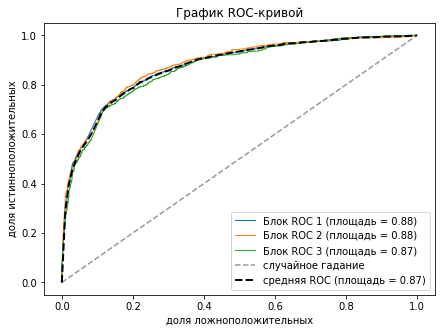

In [10]:
from ML_in_business.CourseProject.toxic_comment.helper_evaluating_model import show_roc_auc
show_roc_auc(X_train, y_train, pipe_clf)

### Обучение модели

In [11]:
pipe_clf.fit(X=X_train, y=y_train)
preds = pipe_clf.predict_proba(X_test)[:, 1]
metric_manager.apply(model_name, y_test, preds)
preds[:10]

c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
100%|██████████| 4324/4324 [00:33<00:00, 128.98it/s]


array([0.2195542 , 0.39229354, 0.37602054, 0.14425092, 0.26952148,
       0.25931105, 0.37602054, 0.29483372, 0.43575837, 0.46528291])

### Посмотрим на графики метрик чтобы выбрать порог

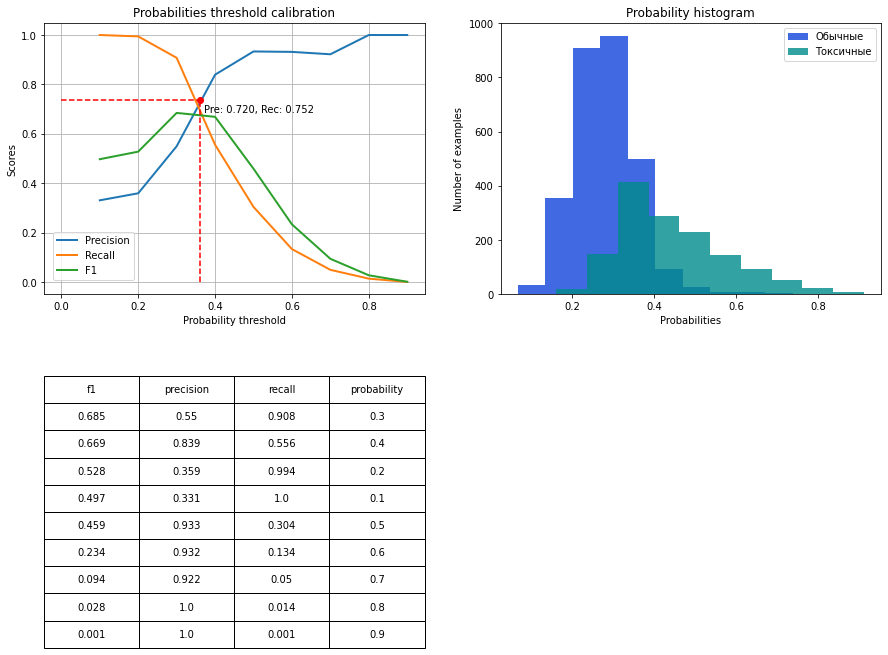

In [12]:
metric_manager.get_experiment(model_name).show_proba_calibration_plots(
    name_positive = 'Обычные',
    name_negative = 'Токсичные'
)

#### Вывод
Судя по графику Probability histogram вероятность определения токсичнычх коментариев смещена в лево из-за чего чаще возникают ошибки на определения токсичных коментариев. Для решения надо попробовать добавить больше признаков для их определения. Возможные признаки это длинна строки, отношение количество знаков препинания к длинне строки, отношение количества ошибок к длинне строки и т.д. Попробовать сбалансировать таргет признак (Undersampling)

### Определим порог срабатывания по f1 score

  Threshold    F-Score    Precision    Recall    Roc-AUC
-----------  ---------  -----------  --------  ---------
      0.362      0.736        0.720     0.752      0.884
Confusion matrix, without normalization


<ipython-input-13-28696a6625e1>:3: DeprecationWarning: Call to deprecated method show_picture. (переработать в более гибкий для использования метод)
  metric.Confusion_matrix.show_picture(


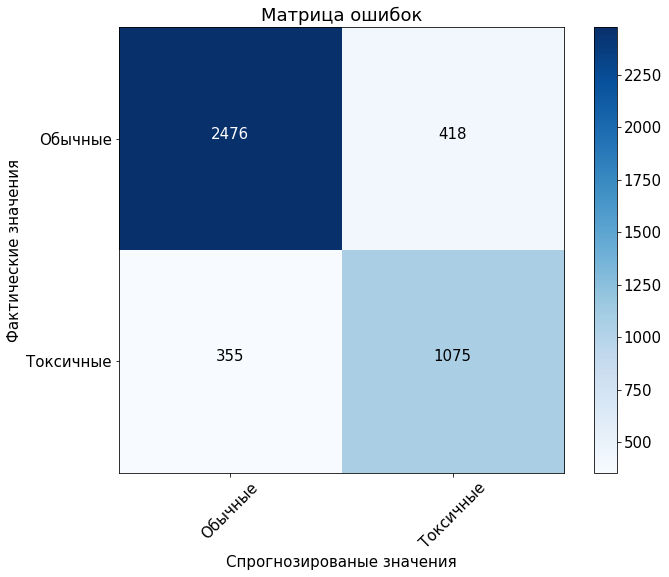

  TPR    FPR    TNR    Precision    Recall    Accuracy
-----  -----  -----  -----------  --------  ----------
0.752  0.144  0.856        0.720     0.752       0.821


In [13]:
metric = metric_manager.calc_metric(name=model_name)
metric.show_table()
metric.Confusion_matrix.show_picture(
    title = 'Матрица ошибок',
    name_positive = 'Обычные',
    name_negative = 'Токсичные'
    )
metric.Confusion_matrix.show_metric()

#### Вывод
1. FPR = 0.13 -> 13% всех комментариев будут помечены как токсичные некорректно
2. TNR = 0.87 -> модель может автоматически фильтровать 87% токсичных комментариев

## Экономическая часть

### Определим порог при готором модель будет наиболее экономически эфективна

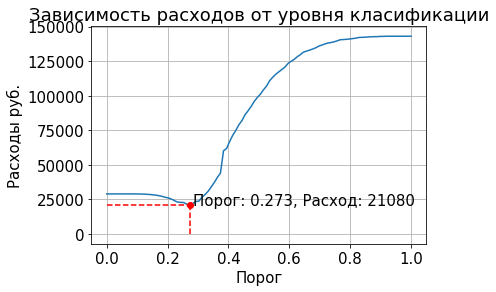

При пороге: 0.273 Минимальный расход будет состовлять: 21080 руб.


In [14]:
threshold, profit = metric_manager.get_experiment(model_name).show_profit_calibration_plots()
print(
    'При пороге: {0:.3f} Минимальный расход будет состовлять: {1} руб.'
    .format(
        threshold,
        profit
    )
)

### Приведем метрику к новому порогу 

Confusion matrix, without normalization


<ipython-input-15-1b5fd7299b1d>:3: DeprecationWarning: Call to deprecated method show_picture. (переработать в более гибкий для использования метод)
  metric.Confusion_matrix.show_picture(


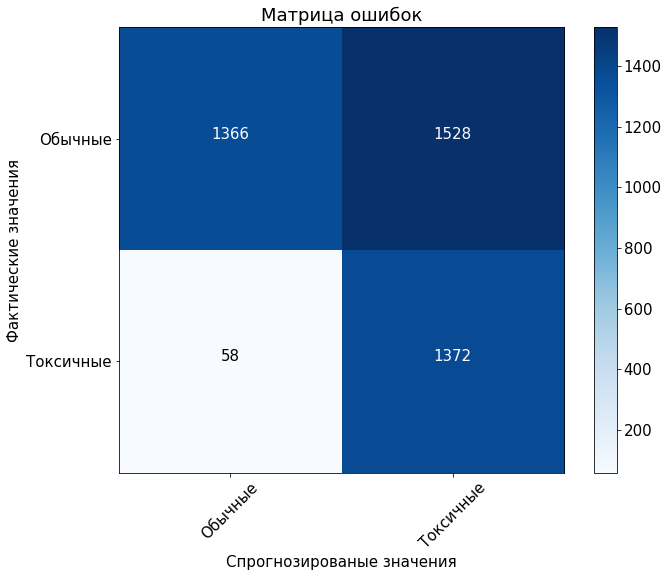

  TPR    FPR    TNR    Precision    Recall    Accuracy
-----  -----  -----  -----------  --------  ----------
0.959  0.528  0.472        0.473     0.959       0.633


In [15]:
profit_threshold = threshold
metric = metric_manager.get_experiment(model_name).calc_metric(specified_thr=profit_threshold)
metric.Confusion_matrix.show_picture(
    title = 'Матрица ошибок',
    name_positive = 'Обычные',
    name_negative = 'Токсичные'
    )
metric.Confusion_matrix.show_metric()


#### Вывод
1. Если максимизировать по затратам то ввидно, что модель стала очень боятся штраф за пропуск токсичных коментарии и готово банить обычные коментарии
2. Если максимизировать по f1 score то модель становится более сбалансированой, но несет дополнительные экономические издержки

## A/B тестирование

Для практики решил провести условное A/B тестирование. Сравнить отличие y_test и y_pred. Как будто результат y_test был получен от группы А. А y_pred результат от группы В
У нас 2 гипотезы:

    # "нулевая" (H0) - наблюдаемые различия незначимы
    # "альтернативная" (H1) - различия значимы

PS код взял из лекций, особо не обрабатывал. Хотел попрактиковаться

In [16]:
y_pred= preds>threshold

z_crit_value = 1.96 #соответствует доверительному интервалу в 95%
k1, n1 = y_test.sum(), y_test.shape[0]
k2, n2 = y_pred.sum(), y_pred.shape[0]
k1, k2, n1, n2

(1430, 2900, 4324, 4324)

In [19]:
p1, p2 = k1/n1, k2/n2
p1, p2

(0.3307123034227567, 0.6706753006475485)

In [20]:
P = (p1*n1+p2*n2)/(n1+n2)
z = (p1-p2)/(P*(1-P)*(1/n1+1/n2))**(1/2)
z

-31.614761367279144

In [21]:
if abs(z) > z_crit_value:
    print("Мы можем отвергнуть нулевую гипотезу!")
else:
    print("Нам не удалось отвергнуть нулевую гипотезу")

Мы можем отвергнуть нулевую гипотезу!


In [22]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =-31.615, pvalue = 0.000


In [23]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =999.493, pvalue = 0.000


### Вывод
Если я все правильно сделал и понял. Т.к. z_crit_value<|z| (1.96<|-31|) отвергаем нулевую гипотезу. Тоже самое говорит и p-value, pvalue = 0.000  меньше 5% (уровня значимости) то нулевая гипотеза отвергается в пользу альтернативной. Получается различия между y_pred и y_test довольно таки значимы